In [1]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer

Load Data

In [2]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'object',
    'RegulatedEntityName': 'string',
    'RegulatedEntityType': 'string',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'string',
    "DonorName": 'string',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'string',
    'RegulatedDoneeType': 'string',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'string',
    'NatureOfDonation': 'string',
    'PurposeOfVisit': 'string',
    'DonationAction': 'string',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'string',
    'AccountingUnitId': 'string',
    'DonorId': 'object',
    'CampaigningName': 'string',
    'RegisterName': 'string',
    'IsIrishSource': 'string'
    },index_col="index")

# DataSummary
summary_df = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df.skew(),
    'Kurtosis':df.kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
summary_df

/tmp/ipykernel_1007/2788242479.py:40: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'SkewScore':df.skew(),
/tmp/ipykernel_1007/2788242479.py:41: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Kurtosis':df.kurtosis()


,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,AcceptedDate,string,6265,64265,1013,NaN,NaN
1,AccountingUnitId,string,2185,36355,28923,NaN,NaN
2,AccountingUnitName,string,1856,56957,8321,NaN,NaN
3,AccountingUnitsAsCentralParty,bool,2,65278,0,3.972770,13.783323
4,CampaigningName,string,3,5,65273,NaN,NaN
5,CompanyRegistrationNumber,string,3558,11480,53798,NaN,NaN
6,DonationAction,string,3,283,64995,NaN,NaN
7,DonationType,string,9,65278,0,NaN,NaN
8,DonorId,object,44739,65197,81,0.630278,-0.531133
9,DonorName,string,19010,65193,85,NaN,NaN


In [3]:
# Remove Currency sign of Value and convert to Float
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)
# Fill blank ReceivedDate with ReportedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportedDate'])
# Fill blank ReceivedDate with AcceptedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['AcceptedDate'])
# convert Received date to Date Format
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y', errors='coerce')
# Convert 'ReportingPeriodName' to datetime if it contains dates at the e
df['ReportingPeriodName_Date'] = pd.to_datetime(
    df['ReportingPeriodName'].str.strip().str[-10:],
    dayfirst=True,
    format='mixed', 
    errors='coerce'
)
# Fill missing 'ReceivedDate' with extracted dates from 'ReportingPeriodName'
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportingPeriodName_Date'])
# Append YearReceived column 
df['YearReceived'] = round(df['ReceivedDate'].dt.year)
# Append MonthReceived column 
df['MonthReceived'] = round(df['ReceivedDate'].dt.month)
# Create YearMonthReceived Column
df['YearMonthReceived'] = round(df['YearReceived']*100 +df['MonthReceived'])
# drop unrequired Columns
df = df.drop(['IsIrishSource', 'RegisterName', 'CampaigningName','AccountingUnitName','AccountingUnitsAsCentralParty','AccountingUnitId','ReportedDate','AcceptedDate','PurposeOfVisit','IsReportedPrePoll', 'ReportingPeriodName_Date'], axis=1)
# drop blank ReceivedDate, DonorID or regulatedEntityName
df = df.dropna(subset = ['ReceivedDate', 'RegulatedEntityName','DonorId','DonorName'])

Review Data to identify Unnecessary Columns and Potential improved Index

In [4]:
# DataSummary post clean
summary_df2 = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df.skew(),
    'Kurtosis':df.kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
summary_df2

/tmp/ipykernel_1007/1982755700.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'SkewScore':df.skew(),
/tmp/ipykernel_1007/1982755700.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Kurtosis':df.kurtosis()


,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,CompanyRegistrationNumber,string,3558,11480,53713,NaN,NaN
1,DonationAction,string,3,256,64937,NaN,NaN
2,DonationType,string,7,65193,0,NaN,NaN
3,DonorId,object,44736,65193,0,0.630371,-0.530975
4,DonorName,string,19010,65193,0,NaN,NaN
5,DonorStatus,string,12,65193,0,NaN,NaN
6,ECRef,object,65193,65193,0,NaN,NaN
7,IsAggregation,bool,2,65193,0,1.165368,-0.641938
8,IsBequest,bool,2,65193,0,9.310707,84.691867
9,IsSponsorship,bool,2,65193,0,8.826138,75.903047


Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [5]:
print(df.groupby('DonorStatus').Value.agg(['sum', 'count']))
print()
print(df.groupby('DonationAction').RegulatedEntityName.agg('count'))
print()
print(df.groupby('DonationType').RegulatedEntityName.agg('count'))
print()
print(df.groupby('NatureOfDonation').Value.agg(['sum', 'count']))
print()
print(df.groupby('IsAggregation').Value.agg(['sum', 'count', 'mean']).round(1))
print()
print(df.groupby('DonationType').Value.agg(['min', 'max', 'sum', 'count', 'mean', 'median']))

                                        sum  count
DonorStatus                                       
Building Society               1.285415e+04      3
Company                        1.892561e+08  11883
Friendly Society               1.522612e+07    659
Impermissible Donor            7.915091e+05    254
Individual                     4.603920e+08  29430
Limited Liability Partnership  7.936854e+06    477
Other                          8.463631e+06   1757
Public Fund                    1.642891e+08   1726
Registered Political Party     3.164690e+06   1029
Trade Union                    1.928190e+08   9926
Trust                          4.855774e+06    640
Unincorporated Association     4.407400e+07   7409

DonationAction
Deferred      16
Forfeited     20
Returned     220
Name: RegulatedEntityName, dtype: int64

DonationType
Cash                              51642
Exempt Trust                        469
Impermissible Donor                 256
Non Cash                           8308
Permi

In [6]:
# create Value_Category based on 10 equal volumed buckets
Groupings = 10
Value_Category_two = pd.qcut(df['Value'],q=Groupings)
df = pd.concat([Value_Category_two, df],axis=1, join="inner")
df.columns.values[0]='Value_Category'
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65193 entries, 0 to 65277
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Value_Category             65193 non-null  category      
 1   ECRef                      65193 non-null  object        
 2   RegulatedEntityName        65193 non-null  string        
 3   RegulatedEntityType        65193 non-null  string        
 4   Value                      65193 non-null  float64       
 5   DonorName                  65193 non-null  string        
 6   IsSponsorship              65193 non-null  bool          
 7   DonorStatus                65193 non-null  string        
 8   RegulatedDoneeType         7089 non-null   string        
 9   CompanyRegistrationNumber  11480 non-null  string        
 10  Postcode                   35013 non-null  string        
 11  DonationType               65193 non-null  string        
 12  Natu

,Value_Category,ECRef,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,...,DonationAction,ReceivedDate,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
index,,,,,,,,,,,,,,,,,,,,,
0,"(1812.804, 2025.0]",NC0408174,Mr Andy Street,Regulated Donee,1876.56,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,...,<NA>,2019-09-02,September 2019,False,False,8015,86310.0,2019.0,9.0,201909.0
1,"(2025.0, 3000.0]",NC0408173,Mr Andy Street,Regulated Donee,2700.00,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,...,<NA>,2019-09-02,September 2019,False,False,8015,86310.0,2019.0,9.0,201909.0
2,"(3000.0, 4994.168]",NC0408177,Mr Andy Street,Regulated Donee,4852.58,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,...,<NA>,2019-08-30,September 2019,False,False,8015,86310.0,2019.0,8.0,201908.0
3,"(2025.0, 3000.0]",NC0408176,Mr Andy Street,Regulated Donee,2500.00,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,...,<NA>,2019-08-30,September 2019,False,False,8015,86310.0,2019.0,8.0,201908.0
4,"(3000.0, 4994.168]",NC0408170,Mr Andy Street,Regulated Donee,4524.05,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,...,<NA>,2019-08-29,September 2019,False,False,8015,86310.0,2019.0,8.0,201908.0


In [7]:
RegulatedEntity_df = df.groupby('RegulatedEntityName').agg({'Value': ['sum', 'count', 'mean']})

RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

RegulatedEntity_df

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Abisola Ifasawo,1650.00,1,1650.000000
Alan Brown,5100.00,1,5100.000000
Alan Mak MP,27693.61,9,3077.067778
Alec Shelbrooke,4860.00,2,2430.000000
Alex Burghart,7800.00,1,7800.000000
...,...,...,...
Yvonne Fovargue MP,6758.06,2,3379.030000
Zac Goldsmith MP,50000.00,1,50000.000000
mums4justice [De-registered 16/05/11],105869.75,12,8822.479167


In [8]:
# Define a function to set the category
def RegulatedEntityGroup(RegulatedEntityNameVar):
    # Define Dictionary with grouped values
    RegEntityGrouping = {0:'No Relevant Donations', 1: 'Single Donation Entity', 10: 'Very Small Entity', 50: 'Small Entity', 100: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    for rangeLimit, category in RegEntityGrouping.items():
        if RE_Events.DonationEvents.agg(sum) <= rangeLimit:
            return category

# Apply the function to create a new column
df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)
# Summary of update from above
df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value         \
                                                          sum  count   
RegEntity_Group                                                        
British National Party [De-registered 08/01/16]  1.406959e+06    142   
Co-operative Party                               1.492238e+07    534   
Conservative and Unionist Party                  4.194008e+08  20351   
Green Party                                      4.976511e+06   1045   
Labour Party                                     3.574923e+08  18121   
Liberal Democrats                                9.682764e+07  12125   
Medium Entity                                    1.914971e+07   1657   
Mr Boris Johnson MP                              1.514047e+06    141   
Plaid Cymru - The Party of Wales                 6.037126e+06    387   
Progress Ltd                                     4.706893e+06    114   
Scottish National Party (SNP)                    2.187422e+07    660   
Scottish Socialist Party                         5.584151e+05    145   
Single Donation Entity                           2.912942e+06    488   
Sinn Féin                                        2.506699e+06    359   
Small Entity                                     4.364938e+07   3756   
The In Campaign Ltd                              2.422811e+07    206   
The New Party [De-registered 01/07/10]           1.382820e+06    146   
UK Independence Party (UKIP)                     1.779199e+07   1809   
Very Small Entity                                3.027103e+07   2756   
Vote Leave Limited                               1.967164e+07    251   

                                                                
                                                          mean  
RegEntity_Group                                                 
British National Party [De-registered 08/01/16]    9908.164225  
Co-operative Party                                27944.522603  
Conservative and Unionist Party                   20608.363216  
Green Party                                        4762.211359  
Labour Party                                      19728.068602  
Liberal Democrats                                  7985.784353  
Medium Entity                                     11556.855335  
Mr Boris Johnson MP                               10737.922908  
Plaid Cymru - The Party of Wales                  15599.807597  
Progress Ltd                                      41288.536491  
Scottish National Party (SNP)                     33142.755803  
Scottish Socialist Party                           3851.138552  
Single Donation Entity                             5969.143115  
Sinn Féin                                          6982.448774  
Small Entity                                      11621.240732  
The In Campaign Ltd                              117612.180097  
The New Party [De-registered 01/07/10]             9471.369041  
UK Independence Party (UKIP)                       9835.260857  
Very Small Entity                                 10983.681720  
Vote Leave Limited                                78373.079681

In [9]:
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']

def GenElectionRelation(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = DaysDiff.days
            return delta
        else:
            pass
    return 0

df['DaysToNextElection'] = df.ReceivedDate.apply(GenElectionRelation)


In [10]:
def GenElectionRelation2(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/7)
            return delta
        else:
            pass
    return 0

df['WeeksToNextElection'] = df.ReceivedDate.apply(GenElectionRelation2)

In [11]:
def GenElectionRelation3(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/91)
            return delta
        else:
            pass
    return 0

df['QtrsToNextElection'] = df.ReceivedDate.apply(GenElectionRelation3)

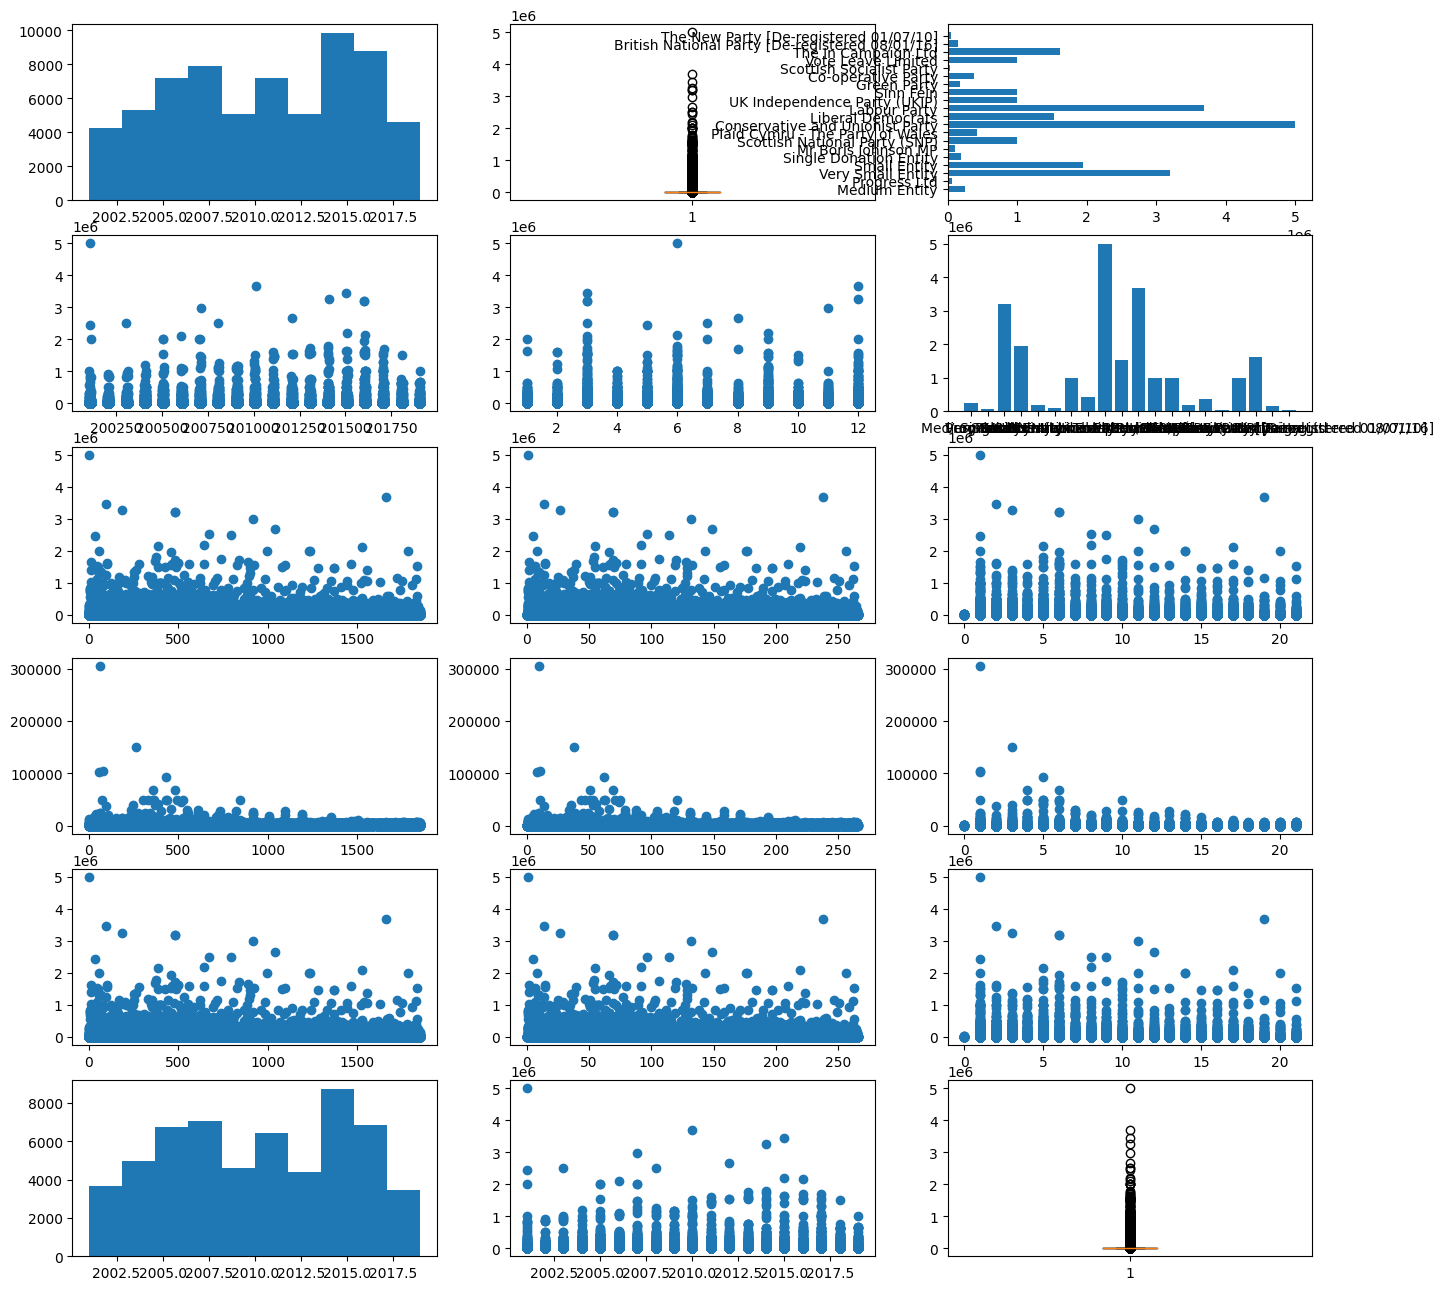

In [13]:

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

axes[0,0].hist(df["YearReceived"])
axes[0,1].boxplot(x=df['Value'] )
axes[0,2].barh(y=df['RegEntity_Group'], width = df['Value'])
axes[1,0].scatter(x=df['YearMonthReceived'], y =df['Value'])
axes[1,1].scatter(x=df['MonthReceived'], y=df['Value'])
axes[1,2].bar(x=df['RegEntity_Group'], height=df['Value'])
axes[2,0].scatter(x=df['DaysToNextElection'], y=df['Value'])
axes[2,1].scatter(x=df['WeeksToNextElection'], y=df['Value'])
axes[2,2].scatter(x=df['QtrsToNextElection'], y=df['Value'])
axes[3,0].scatter(data=df[df['IsAggregation']==True], x='DaysToNextElection', y='Value')
axes[3,1].scatter(data=df[df['IsAggregation']==True], x='WeeksToNextElection', y='Value')
axes[3,2].scatter(data=df[df['IsAggregation']==True], x='QtrsToNextElection', y='Value')
axes[4,0].scatter(data=df[df['IsAggregation']==False], x='DaysToNextElection', y='Value')
axes[4,1].scatter(data=df[df['IsAggregation']==False], x='WeeksToNextElection', y='Value')
axes[4,2].scatter(data=df[df['IsAggregation']==False], x='QtrsToNextElection', y='Value')
axes[5,0].hist(data=df[df['RegulatedEntityType']=='Political Party'], x='YearReceived')
axes[5,1].scatter(data=df[df['RegulatedEntityType']=='Political Party'], x='YearReceived', y='Value')
axes[5,2].boxplot(data=df[df['RegulatedEntityType']=='Political Party'], x='Value')
#df.plot(df[['Value_Category', 'RegulatedEntityType', 'DonorStatus', 'YearReceived']])
plt.show()


In [14]:
RegulatedEntity_df.groupby(['DonationEvents']).agg('sum')

,DonationsValue,DonationMean
DonationEvents,,
1,2.912942e+06,2.912942e+06
2,2.936704e+06,1.468352e+06
3,9.314092e+06,3.104697e+06
4,3.148987e+06,7.872468e+05
5,2.483860e+06,4.967719e+05
...,...,...
1045,4.976511e+06,4.762211e+03
1809,1.779199e+07,9.835261e+03
12125,9.682764e+07,7.985784e+03


<AxesSubplot:xlabel='RegulatedEntityName'>

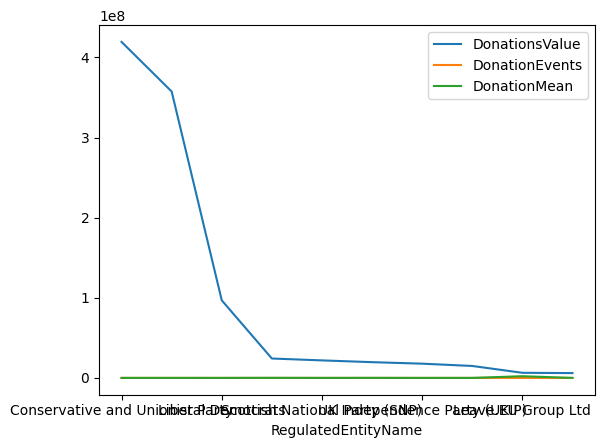

In [15]:
RegulatedEntity_df.sort_values(by=['DonationsValue'], ascending=False).head(n=10).plot()


<AxesSubplot:xlabel='RegulatedEntityName'>

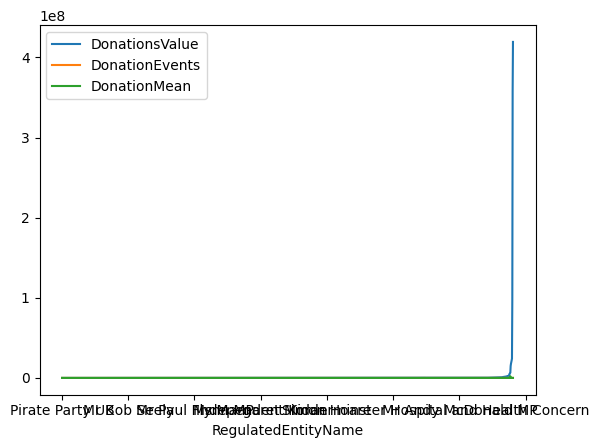

In [16]:
RegulatedEntity_df[RegulatedEntity_df.DonationsValue>0].sort_values(by=['DonationsValue'], ascending=True).plot()

In [17]:
PlotData = df[(df['RegulatedEntityType'] =="Political Party") 
    & (df["RegulatedEntityName"].str.contains('registered')==False)
    ]
PlotData.reindex()

,Value_Category,ECRef,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,...,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived,RegEntity_Group,DaysToNextElection,WeeksToNextElection,QtrsToNextElection
index,,,,,,,,,,,,,,,,,,,,,
72,"(25000.0, 5000000.0]",PF0406817,Scottish National Party (SNP),Political Party,67307.96,House of Commons,False,Public Fund,<NA>,<NA>,...,False,102,33390.0,2019.0,7.0,201907.0,Scottish National Party (SNP),144,21,2
100,"(25000.0, 5000000.0]",PF0407564,Plaid Cymru - The Party of Wales,Political Party,43784.46,Y Comisiwn Etholiadol,False,Public Fund,<NA>,<NA>,...,False,77,87425.0,2019.0,6.0,201906.0,Plaid Cymru - The Party of Wales,171,25,2
122,"(6296.92, 10000.0]",C0406523,The Brexit Party,Political Party,10000.00,Mr Malcolm Bluemel,False,Individual,<NA>,<NA>,...,False,7931,87138.0,2019.0,6.0,201906.0,Small Entity,170,25,2
132,"(10000.0, 25000.0]",NC0407490,Conservative and Unionist Party,Political Party,12000.00,Laurence Stephen Geller,False,Individual,<NA>,<NA>,...,False,52,86338.0,2019.0,6.0,201906.0,Conservative and Unionist Party,167,24,2
135,"(2025.0, 3000.0]",C0406408,Liberal Democrats,Political Party,2300.00,Kendal & South Westmoreland Liberal Club,False,Unincorporated Association,<NA>,<NA>,...,True,90,35426.0,2019.0,6.0,201906.0,Liberal Democrats,193,28,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65269,"(4994.168, 6296.92]",I0033983,Conservative and Unionist Party,Political Party,5900.00,Mr Roger Fletcher,False,Impermissible Donor,<NA>,<NA>,...,False,52,33513.0,2007.0,8.0,200708.0,Conservative and Unionist Party,1019,146,12
65270,"(-0.001, 1000.0]",I0088673,Liberal Democrats,Political Party,1000.00,St Cross Consulting Limited,False,Company,<NA>,<NA>,...,False,90,45945.0,2012.0,12.0,201212.0,Liberal Democrats,935,134,11
65271,"(-0.001, 1000.0]",I0034020,Liberal Democrats,Political Party,1000.00,Mr Ghazi Al-Jumaily,False,Impermissible Donor,<NA>,<NA>,...,False,90,33550.0,2009.0,4.0,200904.0,Liberal Democrats,401,58,5


In [18]:
# Create Summary by DonorId of Total Value of Donations per Year.
df_donoryearValue =df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='sum')
# Create Datafile of Donors by Year showing number of donations
df_donoryearDonations = df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='count')
# Show Donations Value per year
df_donoryearValue.rename_axis('DonorId').reindex()
df_donoryearDonations.rename_axis('DonorId').reindex()
print(df_donoryearDonations.info())

df_donoryearDonations

<class 'pandas.core.frame.DataFrame'>
Index: 44736 entries, 1.0 to 9999.0
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2001.0  2509 non-null   float64
 1   2002.0  1662 non-null   float64
 2   2003.0  2089 non-null   float64
 3   2004.0  3110 non-null   float64
 4   2005.0  4246 non-null   float64
 5   2006.0  2878 non-null   float64
 6   2007.0  3924 non-null   float64
 7   2008.0  3982 non-null   float64
 8   2009.0  5012 non-null   float64
 9   2010.0  4412 non-null   float64
 10  2011.0  1493 non-null   float64
 11  2012.0  1326 non-null   float64
 12  2013.0  1502 non-null   float64
 13  2014.0  2434 non-null   float64
 14  2015.0  2937 non-null   float64
 15  2016.0  2241 non-null   float64
 16  2017.0  2697 non-null   float64
 17  2018.0  1523 non-null   float64
 18  2019.0  1116 non-null   float64
dtypes: float64(19)
memory usage: 6.8+ MB
None


YearReceived,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
DonorId,,,,,,,,,,,,,,,,,,,
1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
